In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import gmean
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import MaxNLocator


# Load the dataset
try:
    df = pd.read_csv('performance_data.csv')
except FileNotFoundError:
    print("Error: data.csv not found. Please ensure the file is in the correct directory.")
    exit()

#### Group datasets by type

In [2]:
# Define dataset groups
dataset_groups = {
  'Road Networks': ['asia_osm', 'europe_osm', 'GAP-road'],
  'RGG': ['rgg_n_2_22_s0'],
  'FEM': ['Hook_1498', 'PFlow_742', 'Geo_1438']
}

# Add a new column to classify datasets by type
df['dataset_type'] = df['dataset'].map(
  lambda x: next((key for key, values in dataset_groups.items() if x in values), 'Unknown')
)

# Verify the grouping
print(df[['dataset', 'dataset_type']].drop_duplicates())

# Define the desired order for plotting
plot_order = ['Road Networks', 'FEM', 'RGG']

# Convert the 'dataset_type' column to a categorical type with the specified order
df['dataset_type'] = pd.Categorical(df['dataset_type'], categories=plot_order, ordered=True)

# Sort the DataFrame to ensure plots are generated in the correct order
df = df.sort_values('dataset_type')

          dataset   dataset_type
0      europe_osm  Road Networks
1       PFlow_742            FEM
3   rgg_n_2_22_s0            RGG
7        Geo_1438            FEM
9       Hook_1498            FEM
19       asia_osm  Road Networks
26       GAP-road  Road Networks


In [3]:
# For pthreads, use the optimal chunksize (64 as seen before)
df_optimal = df[
  (df['implementation'] == 'pthreads') & 
  (
    ((df['num_cpus'] >= 2) & (df['chunksize'] == 64)) | 
    ((df['num_cpus'] == 1) & (df['chunksize'] == 1024))
  ) |
  (df['implementation'] != 'pthreads')
]

# Aggregate data: calculate mean runtime for each configuration
df_optimal = df_optimal.groupby(['implementation', 'num_cpus', 'dataset']).agg(
  runtime=('runtime', gmean),
  std_runtime=('std_runtime', gmean),
  min_runtime=('min_runtime', gmean),
  max_runtime=('max_runtime', gmean),
  dataset_type=('dataset_type', 'first')
).reset_index()



#### Pthreads optimal chunksize

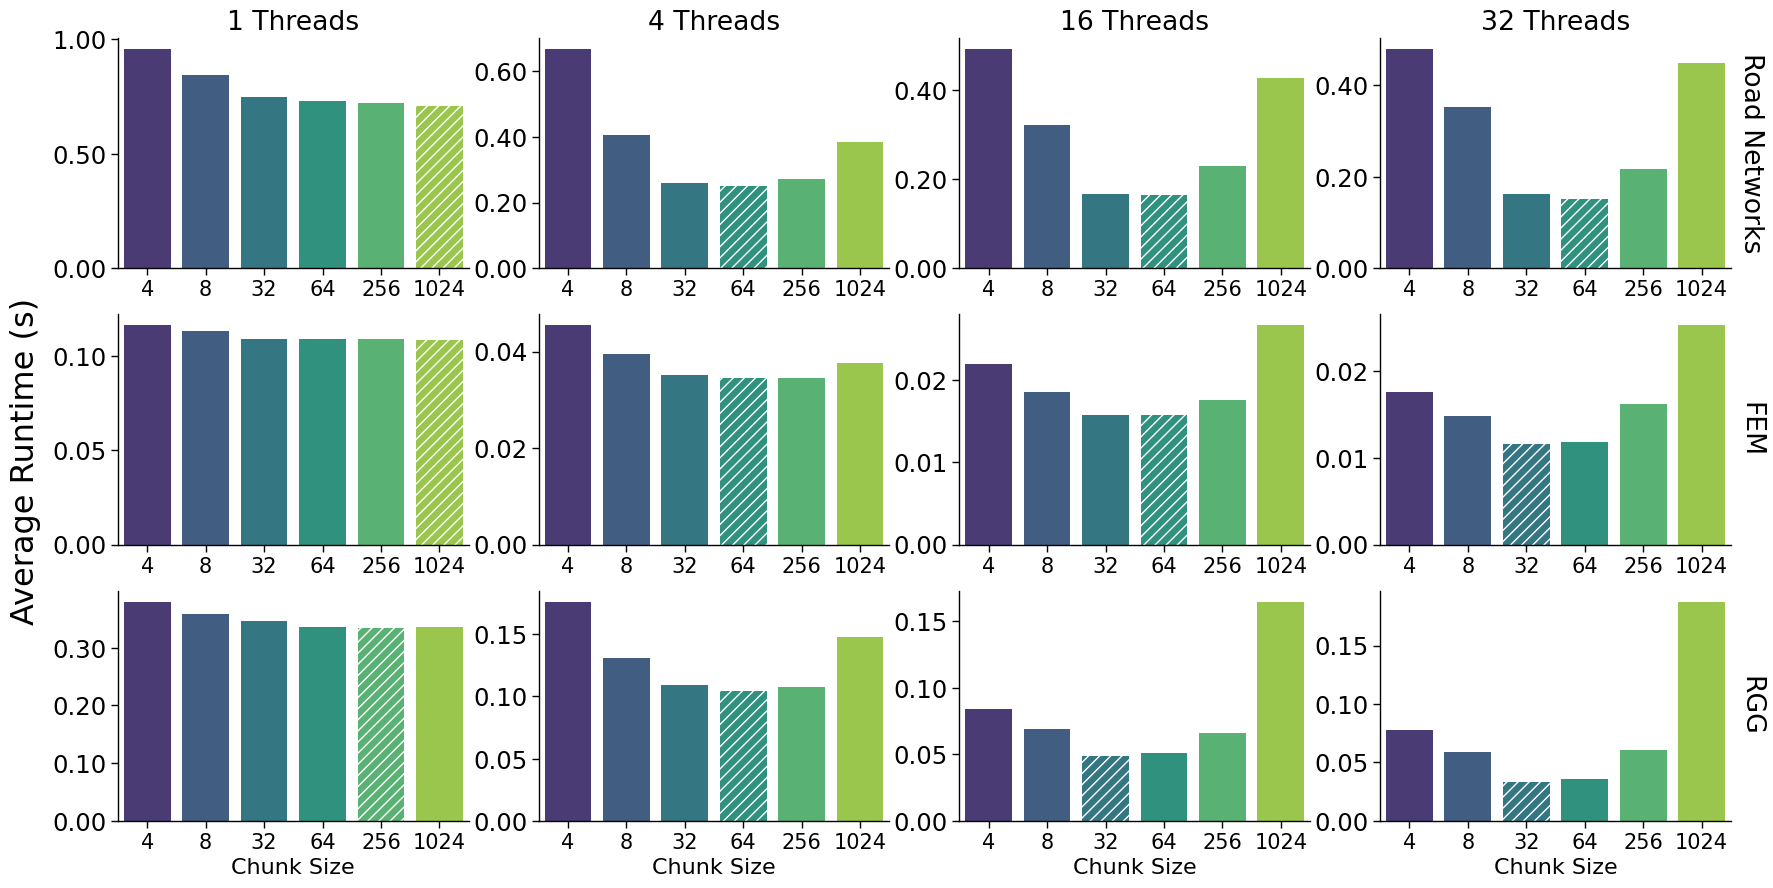

In [4]:
# Filter for the pthreads implementation
pthreads_df = df[df['implementation'] == 'pthreads'].copy()

# Filter for specific CPU counts
cpu_counts = [1, 4, 16, 32]
pthreads_df = pthreads_df[pthreads_df['num_cpus'].isin(cpu_counts)]

pthreads_df = pthreads_df.groupby(['dataset_type', 'num_cpus', 'chunksize'], observed=True).agg(
  runtime=('runtime', gmean),
  std_runtime=('std_runtime', gmean),
  min_runtime=('min_runtime', gmean),
  max_runtime=('max_runtime', gmean)
).reset_index()

pthreads_df = pthreads_df.reset_index()

# Ensure chunksize and num_cpus are treated as categorical for plotting
pthreads_df['chunksize'] = pthreads_df['chunksize'].astype('category')
pthreads_df['num_cpus'] = pthreads_df['num_cpus'].astype('category')

with sns.plotting_context("paper", font_scale=2):
  g = sns.catplot(
      data=pthreads_df,
      x='chunksize',
      y='runtime',
      col='num_cpus',
      row='dataset_type',
      kind='bar',
      height=3,
      aspect=1.5,
      hue='chunksize',
      legend=False,
      palette='viridis',
      margin_titles=True,
      sharey=False, # Runtimes can vary wildly between datasets
      sharex=False,
  )

  # Improve plot aesthetics
  g.figure.supylabel("Average Runtime (s)", x=0.01)  # Moved further left
  g.set_titles(row_template="{row_name}", col_template="{col_name} Threads")

  # Find and highlight the best chunksize in each subplot
  for i, ax in enumerate(g.axes.flat):
      # Get the row and column indices
      row_idx = i // g.axes.shape[1]
      col_idx = i % g.axes.shape[1]
      
      # Get the actual values for this subplot
      dataset_val = g.row_names[row_idx] if hasattr(g, 'row_names') else list(pthreads_df['dataset_type'].unique())[row_idx]
      cpu_val = g.col_names[col_idx] if hasattr(g, 'col_names') else cpu_counts[col_idx]
      
      # Filter data for this specific subplot
      sub_df = pthreads_df[(pthreads_df['dataset_type'] == dataset_val) & (pthreads_df['num_cpus'] == cpu_val)]
      
      if not sub_df.empty:
          # Calculate mean runtime for each chunksize
          mean_runtimes = sub_df.groupby('chunksize', observed=True)['runtime'].mean()
          if not mean_runtimes.empty:
              # Find the best chunksize
              best_chunk_idx = mean_runtimes.idxmin()
              
              # Get the position of best chunksize in the categorical order
              chunk_categories = list(pthreads_df['chunksize'].cat.categories)
              best_position = chunk_categories.index(best_chunk_idx)
              
              # Add hatching to the best chunksize bar
              if best_position < len(ax.patches):
                  ax.patches[best_position].set_hatch('///')
                  ax.patches[best_position].set_edgecolor('white')
                  ax.patches[best_position].set_linewidth(0)

  # Remove x-axis from all subplots since legend provides the chunksize information
  for ax in g.axes.flat:
      ax.set_ylabel('')
      ax.tick_params(axis='x', labelsize=15)
  g.set_axis_labels("Chunk Size", None, fontsize=16)

  # Adjust layout to prevent clipping of top labels
  # g.tight_layout()
  g.figure.subplots_adjust(left=0.07, top=0.97, bottom=0.1, wspace=0.2, hspace=0.2)  # More space on left, top, and bottom

  for ax in g.axes.flat:
      ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

  # Export high-quality PNG for publication
  plt.savefig('pthreads_chunksize.png', 
              dpi=300, 
              bbox_inches='tight', 
              facecolor='white', 
              edgecolor='none',
              format='png')

  plt.show()

#### Scalability

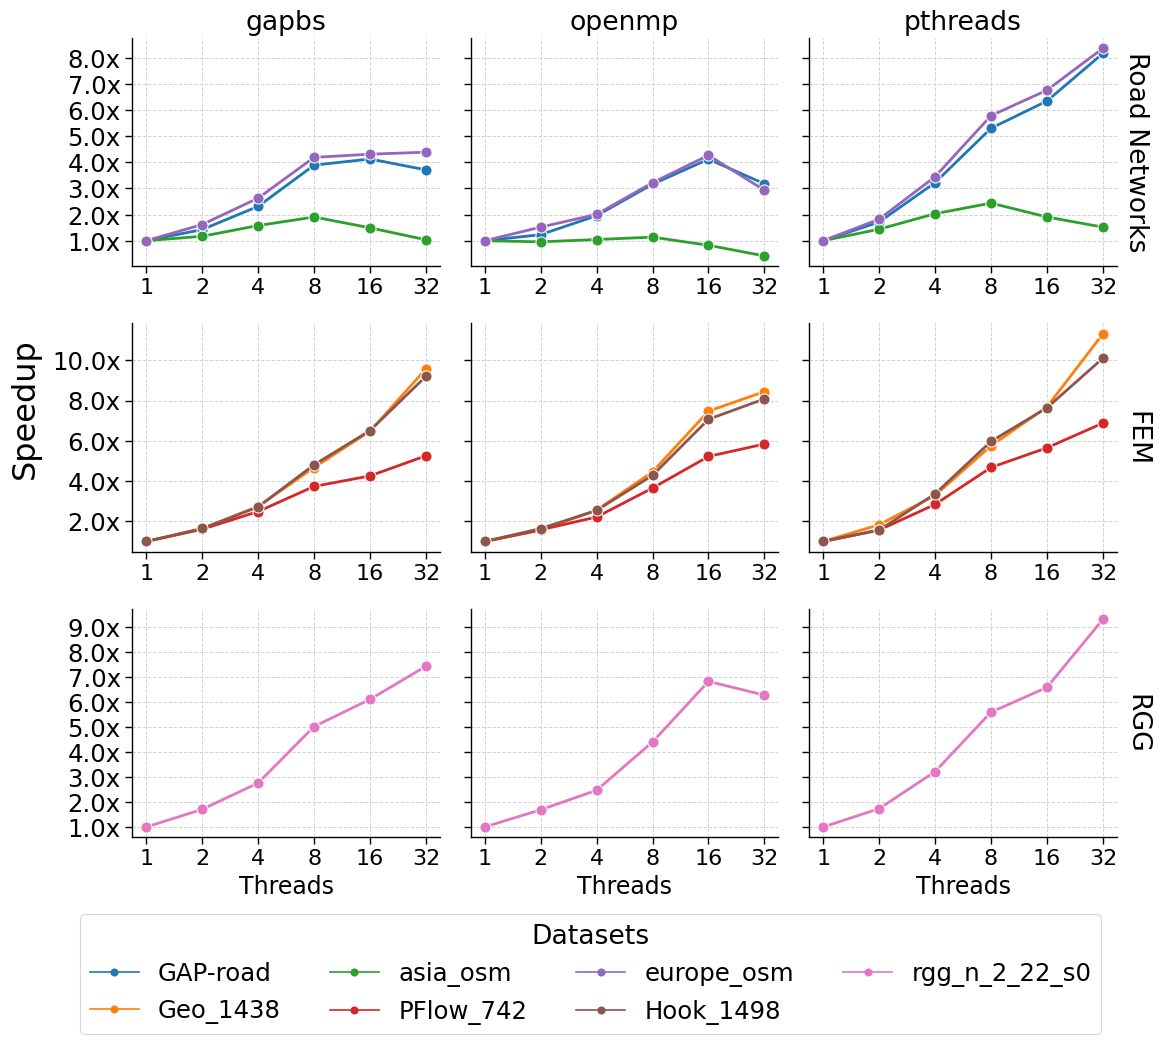

In [5]:
# Sort legend by dataset_type order
legend_order_sorted = ['GAP-road', 'Geo_1438', 'asia_osm', 'PFlow_742', 'europe_osm', 'Hook_1498', 'rgg_n_2_22_s0']
# Compute speedups relative to the single-threaded implementations
df_optimal['speedup'] = df_optimal.groupby(['implementation', 'dataset_type', 'dataset'], observed=True)['runtime'].transform(lambda x: x.iloc[0] / x)

# Use a professional context for fonts and line widths
with sns.plotting_context("paper", font_scale=2):
  g = sns.relplot(
      data=df_optimal,
      x='num_cpus',
      y='speedup',
      col='implementation',
      row='dataset_type',
      hue='dataset',
      hue_order=legend_order_sorted,
      kind='line',
      marker='o',
      height=3.5,
      aspect=1.2,
      facet_kws={'sharex': True, 'sharey': 'row', 'margin_titles': True},
  )
  
  # IMPROVEMENT: Use a lighter grid that doesn't compete with the data
  g.map(plt.grid, which='both', linestyle='--', linewidth=0.7, alpha=1, color='lightgray')
  
  # IMPROVEMENT: Set a single, clear label for the x and y axes

  g.set_axis_labels("Number of threads", "")
  
  # Keep column and row titles simple
  g.set_titles(row_template="{row_name}", col_template="{col_name}")

  # Configure axes for all subplots
  for ax in g.axes.flat:
      ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
      ax.set_xlabel("Threads", fontsize=17)
      for line in ax.lines:
          line.set_linewidth(2)
          line.set_markersize(8)
      # Set x-axis to a base-2 log scale
      ax.set_xscale('log', base=2)
      
      # Set the ticks to be the actual thread counts
      ax.set_xticks(sorted(df_optimal['num_cpus'].unique()))
      ax.yaxis.set_major_locator(MaxNLocator(10, steps=[1, 2, 5]))
      ax.get_xaxis().set_major_formatter(ScalarFormatter())
      # Make sure x-axis tick labels are visible on all plots
      ax.tick_params(axis='x', labelbottom=True)
      ax.get_yaxis().set_major_formatter(FormatStrFormatter('%.1fx'))

  # IMPROVEMENT: Adjust spacing to prevent titles from overlapping
  g.figure.subplots_adjust(left=0.1, wspace=0.1, hspace=0.25)
  g.figure.supylabel("Speedup")  # Moved further left

  # IMPROVEMENT: Adjust legend position and formatting for better readability
  sns.move_legend(
    g,
    loc='upper center', 
    bbox_to_anchor=(0.4, 0.03), # Move legend further down
    ncol=4,
    frameon=True,
    title='Datasets',
  )

  # Export high-quality PNG for publication
  plt.savefig('scalability.png', 
              dpi=300, 
              bbox_inches='tight', 
              facecolor='white', 
              edgecolor='none',
              format='png')
  plt.show()

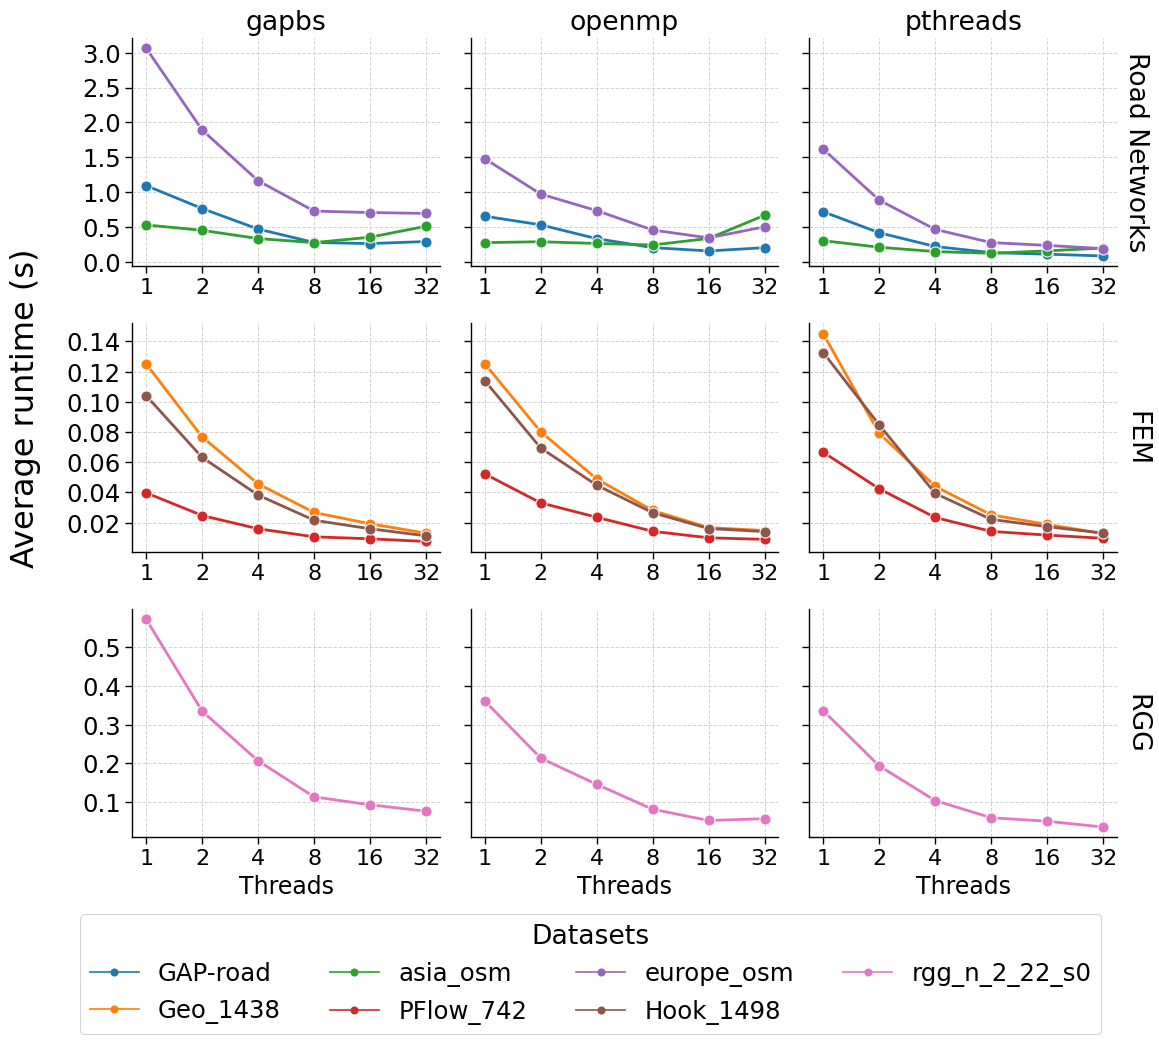

In [6]:
with sns.plotting_context("paper", font_scale=2):
  g = sns.relplot(
      data=df_optimal,
      x='num_cpus',
      y='runtime',
      col='implementation',
      row='dataset_type',
      hue='dataset',
      hue_order=legend_order_sorted,
      kind='line',
      marker='o',
      height=3.5,
      aspect=1.2,
      facet_kws={'sharex': True, 'sharey': 'row', 'margin_titles': True},
  )
  
  # IMPROVEMENT: Use a lighter grid that doesn't compete with the data
  g.map(plt.grid, which='both', linestyle='--', linewidth=0.7, alpha=1, color='lightgray')
  
  # IMPROVEMENT: Set a single, clear label for the x and y axes

  g.set_axis_labels("Number of threads", "")
  
  # Keep column and row titles simple
  g.set_titles(row_template="{row_name}", col_template="{col_name}")

  # Configure axes for all subplots
  for ax in g.axes.flat:
      ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
      ax.set_xlabel("Threads", fontsize=17)
      for line in ax.lines:
          line.set_linewidth(2)
          line.set_markersize(8)
      # Set x-axis to a base-2 log scale
      ax.set_xscale('log', base=2)
      
      # Set the ticks to be the actual thread counts
      ax.set_xticks(sorted(df_optimal['num_cpus'].unique()))
      ax.yaxis.set_major_locator(MaxNLocator(10, steps=[1, 2, 5], prune='upper'))
      ax.get_xaxis().set_major_formatter(ScalarFormatter())
      # Make sure x-axis tick labels are visible on all plots
      ax.tick_params(axis='x', labelbottom=True)

  # IMPROVEMENT: Adjust spacing to prevent titles from overlapping
  g.figure.subplots_adjust(left=0.1, wspace=0.1, hspace=0.25)
  g.figure.supylabel("Average runtime (s)")  # Moved further left

  # IMPROVEMENT: Adjust legend position and formatting for better readability
  sns.move_legend(
    g,
    loc='upper center', 
    bbox_to_anchor=(0.4, 0.03), # Move legend further down
    ncol=4,
    frameon=True,
    title='Datasets',
  )
  plt.show()

#### OpenMP

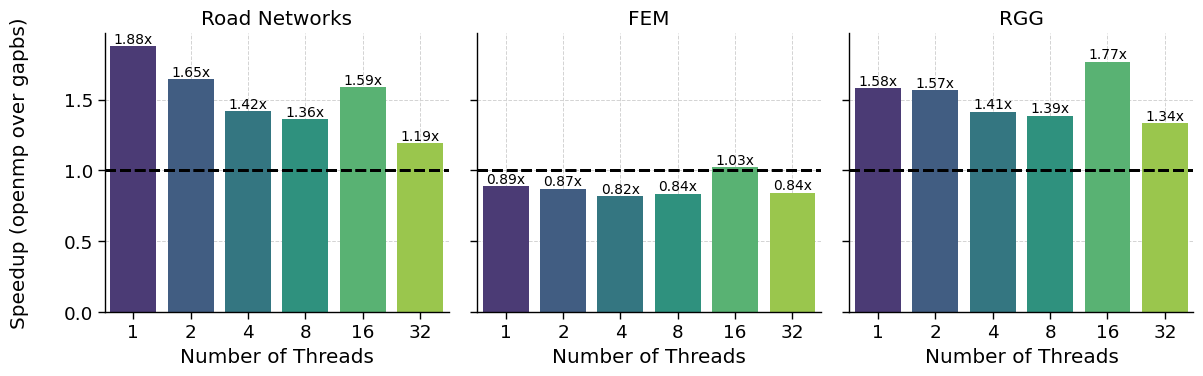

In [7]:
# Isolate the baseline (gapbs) and the version to test (openmp)
df_gapbs = df_optimal[df_optimal['implementation'] == 'gapbs'].copy()
df_openmp = df_optimal[df_optimal['implementation'] == 'openmp'].copy()

# Merge the two dataframes to align runtimes for each test case
# The key identifies a unique run: same dataset, type, and cpu count
merge_keys = ['dataset_type', 'num_cpus', 'dataset']
speedup_df = pd.merge(
    df_gapbs[merge_keys + ['runtime']],
    df_openmp[merge_keys + ['runtime']],
    on=merge_keys,
    suffixes=('_gapbs', '_openmp')
)

# Calculate speedup: Runtime_baseline / Runtime_new
speedup_df['speedup'] = speedup_df['runtime_gapbs'] / speedup_df['runtime_openmp']

# Group by dataset type and number of threads, then find the average speedup
speedup_agg_df = speedup_df.groupby(['dataset_type', 'num_cpus'], observed=True).agg(
    avg_speedup=('speedup', 'mean')
).reset_index()

speedup_agg_df['num_cpus'] = speedup_agg_df['num_cpus'].astype('category')

# Create the plot
with sns.plotting_context("paper", font_scale=1.5):
    g = sns.catplot(
      data=speedup_agg_df,
      x='num_cpus',
      y='avg_speedup',
      col='dataset_type',
      col_wrap=4,
      legend=False,
      kind='bar',
      height=4,
      aspect=1,
      sharey=True,
      palette='viridis',
      hue='num_cpus',
    )
    # Add speedup value on top of each bar
    for ax in g.axes.flat:
      for bar in ax.patches:
        ax.grid(which='both', linestyle='--', linewidth=0.7, alpha=1, color='lightgray')
        ax.axhline(y=1, color='black', linestyle='--', linewidth=2, alpha=1, zorder=2)
        ax.set_axisbelow(True)
        height = bar.get_height()
        if not pd.isna(height) and height > 0:
          ax.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f'{height:.2f}x',
            ha='center',
            va='bottom',
            fontsize=10
          )

    # Set plot aesthetics
    g.set_axis_labels("Number of Threads", "Speedup (openmp over gapbs)")
    g.set_titles("{col_name}")
    # Move y-axis label slightly to the left
    for ax in g.axes.flat:
      ax.yaxis.set_label_coords(-0.22, 0.5)
    # Adjust layout
    plt.tight_layout()

    plt.savefig('speedup_openmp.png', 
                dpi=300, 
                bbox_inches='tight', 
                facecolor='white', 
                edgecolor='none',
                format='png')

    plt.show()

In [8]:
# Filter for Road Networks and RGG graphs
road_network_speedup = speedup_df[speedup_df['dataset_type'] == 'Road Networks']['speedup'].dropna()
rgg_speedup = speedup_df[speedup_df['dataset_type'] == 'RGG']['speedup'].dropna()

# Compute geometric mean speedup
road_network_geomean = gmean(road_network_speedup)
rgg_geomean = gmean(rgg_speedup)

print(f"Geometric mean speedup for Road Networks: {road_network_geomean:.2f}")
print(f"Geometric mean speedup for RGG graphs: {rgg_geomean:.2f}")

Geometric mean speedup for Road Networks: 1.47
Geometric mean speedup for RGG graphs: 1.50


#### Pthreads

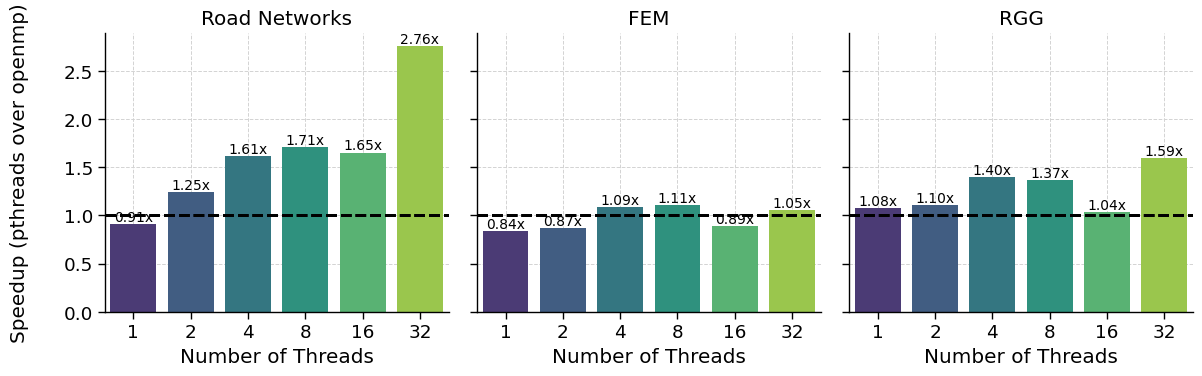

In [9]:
# Isolate the baseline (pthreads) and the version to test (openmp)
df_pthreads = df_optimal[df_optimal['implementation'] == 'pthreads'].copy()
df_openmp = df_optimal[df_optimal['implementation'] == 'openmp'].copy()

# Merge the two dataframes to align runtimes for each test case
# The key identifies a unique run: same dataset, type, and cpu count
merge_keys = ['dataset_type', 'num_cpus', 'dataset']
speedup_df_pthreads = pd.merge(
  df_pthreads[merge_keys + ['runtime']],
  df_openmp[merge_keys + ['runtime']],
  on=merge_keys,
  suffixes=('_pthreads', '_openmp')
)

# Calculate speedup: Runtime_baseline / Runtime_new
speedup_df_pthreads['speedup'] = speedup_df_pthreads['runtime_openmp'] / speedup_df_pthreads['runtime_pthreads']

# Group by dataset type and number of threads, then find the average speedup
speedup_agg_df_pthreads = speedup_df_pthreads.groupby(['dataset_type', 'num_cpus'], observed=True).agg(
  avg_speedup=('speedup', 'mean')
).reset_index()

speedup_agg_df_pthreads['num_cpus'] = speedup_agg_df_pthreads['num_cpus'].astype('category')

# Create the plot
with sns.plotting_context("paper", font_scale=1.5):
  g = sns.catplot(
    data=speedup_agg_df_pthreads,
    x='num_cpus',
    y='avg_speedup',
    col='dataset_type',
    col_wrap=4,
    legend=False,
    kind='bar',
    height=4,
    aspect=1,
    sharey=True,
    palette='viridis',
    hue='num_cpus',
  )

  # --- FIX: Loop through axes to re-enable Y-tick labels on all subplots ---
  for ax in g.axes.flat:
    for bar in ax.patches:
      ax.grid(which='both', linestyle='--', linewidth=0.7, alpha=1, color='lightgray')
      ax.axhline(y=1, color='black', linestyle='--', linewidth=2, alpha=1, zorder=2)
      ax.set_axisbelow(True)
      height = bar.get_height()
      if not pd.isna(height) and height > 0:
        ax.text(
          bar.get_x() + bar.get_width() / 2,
          height,
          f'{height:.2f}x',
          ha='center',
          va='bottom',
          fontsize=10
        )

  # Set plot aesthetics
  g.set_axis_labels("Number of Threads", "Speedup (pthreads over openmp)")
  g.set_titles("{col_name}")
  # Move y-axis label slightly to the left
  for ax in g.axes.flat:
    ax.yaxis.set_label_coords(-0.22, 0.5)
  # Adjust layout
  plt.tight_layout()

  plt.savefig('speedup_pthreads.png', 
        dpi=300, 
        bbox_inches='tight', 
        facecolor='white', 
        edgecolor='none',
        format='png')

  plt.show()

In [10]:
# Filter for Road Networks and RGG graphs
road_network_speedup = speedup_df_pthreads[speedup_df['dataset_type'] == 'Road Networks']['speedup'].dropna()
rgg_speedup = speedup_df_pthreads[speedup_df['dataset_type'] == 'RGG']['speedup'].dropna()

# Compute geometric mean speedup
road_network_geomean = gmean(road_network_speedup)
rgg_geomean = gmean(rgg_speedup)

print(f"Geometric mean speedup for Road Networks: {road_network_geomean:.2f}")
print(f"Geometric mean speedup for RGG graphs: {rgg_geomean:.2f}")

Geometric mean speedup for Road Networks: 1.55
Geometric mean speedup for RGG graphs: 1.25


In [11]:
# Merge the two dataframes to align runtimes for each test case
# The key identifies a unique run: same dataset, type, and cpu count
merge_keys = ['dataset_type', 'num_cpus', 'dataset']
speedup_df_pthreads_gapbs = pd.merge(
  df_pthreads[merge_keys + ['runtime']],
  df_gapbs[merge_keys + ['runtime']],
  on=merge_keys,
  suffixes=('_pthreads', '_gapbs')
)

# Calculate speedup: Runtime_baseline / Runtime_new
speedup_df_pthreads_gapbs['speedup'] = speedup_df_pthreads_gapbs['runtime_gapbs'] / speedup_df_pthreads_gapbs['runtime_pthreads']

# Filter for Road Networks and RGG graphs
road_network_speedup = speedup_df_pthreads_gapbs[speedup_df['dataset_type'] == 'Road Networks']['speedup'].dropna()
rgg_speedup = speedup_df_pthreads_gapbs[speedup_df['dataset_type'] == 'RGG']['speedup'].dropna()
print(speedup_df_pthreads_gapbs[speedup_df['dataset_type'] == 'Road Networks']['speedup'].max())

# Print max speedup
print(speedup_df_pthreads_gapbs[speedup_df_pthreads_gapbs['dataset_type'] == 'Road Networks'].loc[speedup_df_pthreads_gapbs['speedup'].idxmax()])

# Compute geometric mean speedup
road_network_geomean = gmean(road_network_speedup)
rgg_geomean = gmean(rgg_speedup)

print(f"Geometric mean speedup for Road Networks: {road_network_geomean:.2f}")
print(f"Geometric mean speedup for RGG graphs: {rgg_geomean:.2f}")

3.606368755929553
dataset_type        Road Networks
num_cpus                       32
dataset                europe_osm
runtime_pthreads         0.193391
runtime_gapbs            0.697439
speedup                  3.606369
Name: 40, dtype: object
Geometric mean speedup for Road Networks: 2.28
Geometric mean speedup for RGG graphs: 1.87


#### Other platforms

In [12]:
# Load the additional datasets
df_boards = pd.DataFrame()
try:
    df_risc = pd.read_csv('data_risc.csv')
    df_grace = pd.read_csv('data_grace.csv')
    df['board'] = 'amd'
    df_grace['board'] = 'grace'
    # Combine all dataframes
    df_boards = pd.concat([df, df_risc, df_grace], ignore_index=True)
    
except FileNotFoundError as e:
    print(f"Error: {e.filename} not found. Please ensure the file is in the correct directory.")

# Display the boards to verify they have been loaded
print("Available boards in the dataframe:")
print(df_boards['board'].unique())
print(df_boards['implementation'].unique())

Available boards in the dataframe:
['amd' 'pioneer' 'bananaf3' 'arriesgado' 'grace']
['pthreads' 'openmp' 'gapbs' 'atomic' 'mcslock' 'mutex']


In [13]:
# Filter for the pthreads implementation
pthreads_df = df_boards[((df_boards['implementation'] == 'pthreads') | (df_boards['implementation'] == 'mutex')) & (df_boards['dataset'] == 'europe_osm')].copy()

pthreads_df = pthreads_df[
  ((pthreads_df['num_cpus'] >= 2) & (pthreads_df['chunksize'] == 64)) | 
  ((pthreads_df['num_cpus'] == 1) & (pthreads_df['chunksize'] == 1024))
]
pthreads_df = pthreads_df[pthreads_df['num_cpus'].isin([1, 2, 4, 8, 16, 32])]
pthreads_df = pthreads_df[pthreads_df['board'].isin(['amd', 'grace', 'pioneer'])]

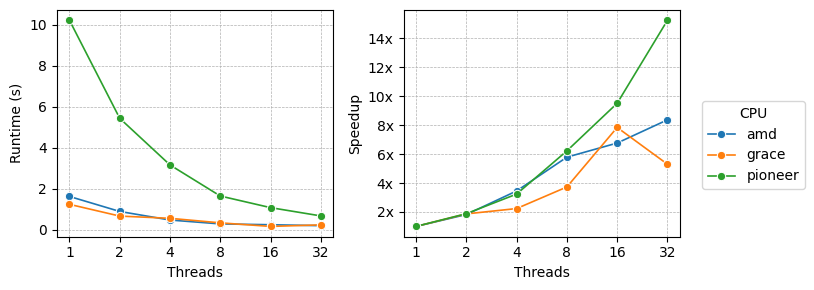

In [16]:
# Compute strong scaling: speedup relative to the single-threaded runtime
pthreads_df = pthreads_df.sort_values(by=['num_cpus'])
pthreads_df['strong_scaling'] = pthreads_df.groupby(['board', 'dataset'], observed=True)['runtime'].transform(lambda x: x.iloc[0] / x)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(7, 3))

# Create a line plot for runtime vs num_cpus for different boards
with sns.plotting_context("paper", font_scale=1.5):
  ax = axes[0]
  sns.lineplot(
    data=pthreads_df,
    x='num_cpus',
    y='runtime',
    hue='board',
    marker='o',
    markersize=6,
    ax=ax
  )

  ax.set_xlabel("Threads")
  ax.set_ylabel("Runtime (s)")

  # Set x-axis to a base-2 log scale for better visualization of scalability
  ax.set_xscale('log', base=2)
  
  # Ensure all CPU counts are shown as ticks
  unique_cpus = sorted(pthreads_df['num_cpus'].unique())
  ax.set_xticks(unique_cpus)
  ax.get_xaxis().set_major_formatter(ScalarFormatter())

  # Improve grid and legend
  ax.grid(which='both', linestyle='--', linewidth=0.5)

# Create a line plot for speedup vs num_cpus for different boards
with sns.plotting_context("paper", font_scale=1.5):
  ax = axes[1]
  sns.lineplot(
    data=pthreads_df,
    x='num_cpus',
    y='strong_scaling',
    hue='board',
    marker='o',
    markersize=6,
    ax=ax,
  )

  ax.set_xlabel("Threads")
  ax.set_ylabel("Speedup")

  # Set x-axis to a base-2 log scale for better visualization of scalability
  ax.set_xscale('log', base=2)
  
  # Ensure all CPU counts are shown as ticks
  unique_cpus = sorted(pthreads_df['num_cpus'].unique())
  ax.set_xticks(unique_cpus)
  ax.get_xaxis().set_major_formatter(ScalarFormatter())

  # Improve grid and legend
  ax.grid(which='both', linestyle='--', linewidth=0.5)
  ax.get_yaxis().set_major_formatter(FormatStrFormatter('%ix'))

# Remove legend from individual plots
for ax in axes:
  ax.legend_.remove()

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="center left", bbox_to_anchor=(1, 0.5), title="CPU")

plt.tight_layout()

plt.savefig('other_platforms.png', 
  dpi=300, 
  bbox_inches='tight', 
  facecolor='white', 
  edgecolor='none',
  format='png')

plt.show()

In [15]:
pthreads_df[pthreads_df['num_cpus'] == 32]

,board,implementation,dataset,num_cpus,chunksize,runtime,std_runtime,min_runtime,max_runtime,dataset_type,Unnamed: 0,strong_scaling
991,pioneer,mutex,europe_osm,32,64,0.669430,NaN,NaN,NaN,NaN,655.0,15.246050
78,amd,pthreads,europe_osm,32,64,0.193391,0.011726,0.1804,0.2223,Road Networks,NaN,8.366493
1532,grace,mutex,europe_osm,32,64,0.232799,0.015947,0.2125,0.2767,NaN,NaN,5.300219
